In [1]:
import numbers
from collections import Counter
from scipy.stats import mode
from sklearn.utils import _safe_indexing
from sklearn.utils._param_validation import HasMethods, Interval, StrOptions
import pandas as pd
import numpy as np
import seaborn as sns    
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler  
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.metrics import geometric_mean_score
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import precision_recall_curve, roc_curve, f1_score
from xgboost import XGBClassifier
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras import layers, models, datasets
from scikeras.wrappers import KerasClassifier
from sklearn.model_selection import train_test_split
from feature_engine.encoding import OneHotEncoder
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.metrics import (f1_score, roc_auc_score, average_precision_score, 
                             accuracy_score, matthews_corrcoef, recall_score, 
                             precision_score, confusion_matrix)

In [2]:
df = pd.read_csv('D:/My Thesis/data in spss/imputed_Extra_tree .csv')
df = df.drop('ID' ,axis = 1)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2744 entries, 0 to 2743
Data columns (total 50 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Hospital_outcome         2744 non-null   int64
 1   Sex                      2744 non-null   int64
 2   Digestive_underlying     2744 non-null   int64
 3   Respiratory_underlying   2744 non-null   int64
 4   Infectious_underlying    2744 non-null   int64
 5   Fatness_underlying       2744 non-null   int64
 6   Urinary_underlying       2744 non-null   int64
 7   Diabete_underlying       2744 non-null   int64
 8   Hypertension (HTN)       2744 non-null   int64
 9   Heart_underlying         2744 non-null   int64
 10  Nervous_underlying       2744 non-null   int64
 11  Blooddisease_underlying  2744 non-null   int64
 12  Convulsions              2744 non-null   int64
 13  Identifying people       2744 non-null   int64
 14  Motionless               2744 non-null   int64
 15  Resp

In [4]:
X=df.drop('Hospital_outcome',axis=1)
y=df['Hospital_outcome']

In [5]:
categorical_features = ['Sex','Digestive_underlying', 'Respiratory_underlying','Infectious_underlying','Fatness_underlying', 'Urinary_underlying',
'Diabete_underlying', 'Hypertension (HTN)','Heart_underlying','Nervous_underlying', 'Blooddisease_underlying','Opiate', 'Education', 
 'Urinary_Incontinence', 'Previous_recurrent', 'Noconsious', 'GCS','Receivingblood', 'Conciousness', 'Mode of Arrival', 'Awareness of time',
'Stroke type', 'Treatment_method', 'Pneumonia', 'Convulsions','Identifying people', 'Motionless','Respiratory', 'Heart', 'Edema', 'Bloody',
'Vision_impairment', 'Sensory', 'Headache', 'Blurred_Vision','Reduce_strength_limb', 'Lackofbalance', 'Weakness', 'Delirium','Skin_problems',
'Aphasia_and_Dysarthria', 'Cranial_nerve_Disorder','Paralyzed', 'Digestive_problems']  # Replace with your categorical column names
numeric_features = ['Age','RR','HR','systolic','LOS (days)']
df[categorical_features] = df[categorical_features].astype('category')

In [6]:
# Initial train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=101)

# OneHotEncoder and StandardScaler 

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numeric_features)
    ])

# IsolationForest

In [8]:
from sklearn.ensemble import IsolationForest
# Outlier detection (on training data only)
outlier_detector = IsolationForest(contamination=0.05, random_state=101)
outliers = outlier_detector.fit_predict(preprocessor.fit_transform(X_train))
inlier_mask = outliers != -1

In [9]:
# Apply outlier removal
X_train_clean, y_train_clean = X_train.iloc[inlier_mask], y_train.iloc[inlier_mask]

In [10]:
X_train_clean.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1824 entries, 2253 to 1388
Data columns (total 49 columns):
 #   Column                   Non-Null Count  Dtype
---  ------                   --------------  -----
 0   Sex                      1824 non-null   int64
 1   Digestive_underlying     1824 non-null   int64
 2   Respiratory_underlying   1824 non-null   int64
 3   Infectious_underlying    1824 non-null   int64
 4   Fatness_underlying       1824 non-null   int64
 5   Urinary_underlying       1824 non-null   int64
 6   Diabete_underlying       1824 non-null   int64
 7   Hypertension (HTN)       1824 non-null   int64
 8   Heart_underlying         1824 non-null   int64
 9   Nervous_underlying       1824 non-null   int64
 10  Blooddisease_underlying  1824 non-null   int64
 11  Convulsions              1824 non-null   int64
 12  Identifying people       1824 non-null   int64
 13  Motionless               1824 non-null   int64
 14  Respiratory              1824 non-null   int64
 15  Heart 

In [11]:
y_train_clean.value_counts(normalize = True)

Hospital_outcome
0    0.855811
1    0.144189
Name: proportion, dtype: float64

In [12]:
# Preprocess cleaned training data
X_train_preprocessed = preprocessor.transform(X_train_clean)
# Evaluate on test set
X_test_preprocessed = preprocessor.transform(X_test)

In [13]:
feature_names = preprocessor.get_feature_names_out()

# Create  XGBoost Model

In [14]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [15]:

xgb_model = XGBClassifier(use_label_encoder=True, eval_metric='logloss', random_state=101)
param_grid = {
    'max_depth': [3, 5, 7],
    'learning_rate': [0.1, 0.2, 0.3],
    'n_estimators': [20, 50, 100],
    'gamma': [0, 0.1, 0.2],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train_preprocessed, y_train_clean)

print("Best parameters found:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)


Fitting 5 folds for each of 1458 candidates, totalling 7290 fits
Best parameters found: {'colsample_bytree': 0.8, 'gamma': 0.2, 'learning_rate': 0.2, 'max_depth': 7, 'min_child_weight': 5, 'n_estimators': 50, 'subsample': 0.8}
Best cross-validation accuracy: 0.8963962065331929


In [16]:
'''
y_pred = grid_search.best_estimator_.predict(test_t)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
'''

'\ny_pred = grid_search.best_estimator_.predict(test_t)\nprint(classification_report(y_test, y_pred))\nprint(confusion_matrix(y_test, y_pred))\n'

In [17]:
xgb_model = XGBClassifier(use_label_encoder=True, eval_metric='logloss',colsample_bytree=0.8, gamma=0.2,
learning_rate=0.2,max_depth=7, min_child_weight=5,n_estimators=50,subsample =0.8,random_state=101,verbose=1,n_jobs=-1)
xgb_model.fit(X_train_preprocessed, y_train_clean)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.2,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.2, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=7, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=-1,
              num_parallel_tree=None, ...)

In [18]:
y_pred = xgb_model.predict(X_test_preprocessed)
xgb_probs = xgb_model.predict_proba(X_test_preprocessed)[:, 1]  # Probabilities for the positive class (class 1)
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))
print("Test Accuracy:", accuracy_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.97      0.93       689
           1       0.73      0.41      0.53       135

    accuracy                           0.88       824
   macro avg       0.81      0.69      0.73       824
weighted avg       0.87      0.88      0.86       824

[[668  21]
 [ 79  56]]
Test Accuracy: 0.8786407766990292


In [19]:
# After preprocessing and model training
feature_names = preprocessor.get_feature_names_out()

# Get feature importances
importance_scores = xgb_model.feature_importances_

# Pair names with scores and sort
feature_importance = sorted(
    zip(feature_names, importance_scores),
    key=lambda x: x[1],
    reverse=True
)

# Print with names
print("Top 20 Features by Importance:")
for name, score in feature_importance[:20]:
    print(f"{name}: {score:.4f}")

Top 20 Features by Importance:
cat__GCS_1: 0.1438
cat__Conciousness_1: 0.0619
cat__GCS_3: 0.0606
cat__Mode of Arrival_3: 0.0538
cat__GCS_2: 0.0324
cat__Awareness of time_1: 0.0317
cat__Respiratory_1: 0.0314
cat__Respiratory_0: 0.0311
cat__Identifying people_0: 0.0238
cat__Lackofbalance_0: 0.0212
cat__Digestive_problems_1: 0.0163
cat__Urinary_Incontinence_0: 0.0160
cat__Respiratory_underlying_0: 0.0157
cat__Noconsious_0: 0.0153
cat__Heart_underlying_1: 0.0150
cat__Convulsions_0: 0.0144
cat__Conciousness_3: 0.0140
num__LOS (days): 0.0138
cat__Convulsions_1: 0.0135
cat__Digestive_problems_0: 0.0128


In [20]:
# SHAP Explainer
import shap
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_test_preprocessed)

# Initialize the SHAP JavaScript library
shap.initjs()

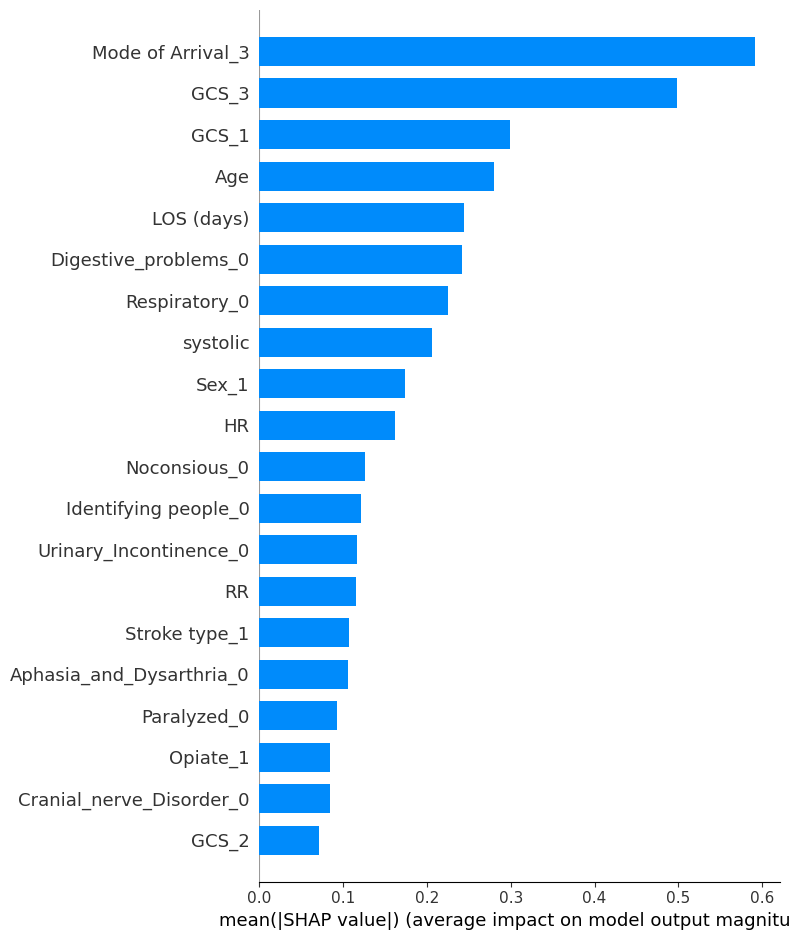

In [21]:
feature_names_clean = [name.split('__')[-1] for name in feature_names]
X_test_clean = pd.DataFrame(X_test_preprocessed, columns=feature_names_clean)
shap.summary_plot(shap_values, X_test_clean, plot_type="bar", show=True)


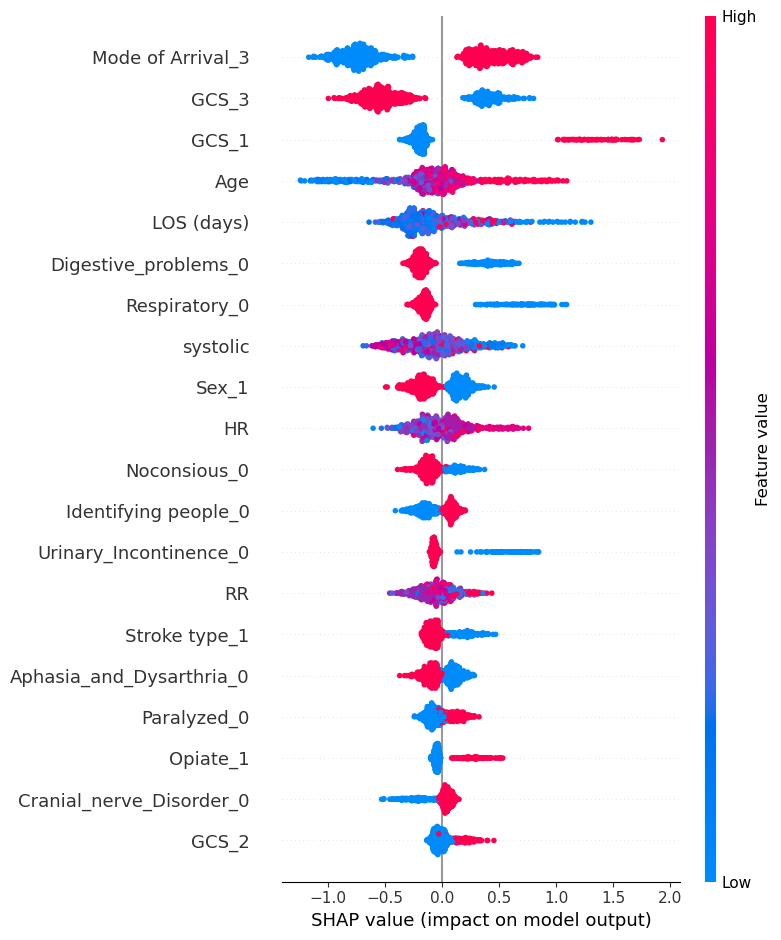

In [22]:
shap.summary_plot(shap_values, X_test_clean, plot_type="dot", show=True)

In [23]:
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
# Calculate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

In [24]:
# Convert confusion matrix to percentages
cm_percent = cm / cm.sum(axis=1)[:, np.newaxis] * 100

In [25]:
# Print confusion matrix (counts)
print("Confusion Matrix (Counts):")
print(cm)

Confusion Matrix (Counts):
[[668  21]
 [ 79  56]]


In [26]:
# Print confusion matrix (percentages)
print("\nConfusion Matrix (Percentages):")
print(cm_percent)


Confusion Matrix (Percentages):
[[96.9521045   3.0478955 ]
 [58.51851852 41.48148148]]


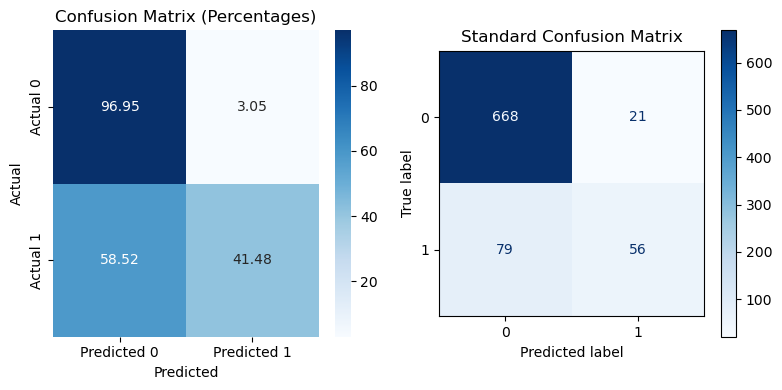

In [27]:
# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))

# First plot: Percentage confusion matrix (Seaborn)
sns.heatmap(cm_percent, annot=True, fmt='.2f', cmap='Blues', 
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'],
            ax=ax1)
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual')
ax1.set_title('Confusion Matrix (Percentages)')

# Second plot: Standard confusion matrix (Scikit-learn)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
                             display_labels=xgb_model.classes_)
disp.plot(cmap='Blues', ax=ax2)
ax2.set_title('Standard Confusion Matrix')

# Adjust layout and display
plt.tight_layout()
plt.show()

In [28]:
# Calculate and print the error rate and the number of misclassifications
err = 1 - accuracy_score(y_test, y_pred)
n_miss = np.sum(y_pred != y_test)
print(f"Error Rate: {err}")
print(f"Number of Misclassifications: {n_miss}")

Error Rate: 0.12135922330097082
Number of Misclassifications: 100


In [29]:
from sklearn.metrics import confusion_matrix, f1_score
from sklearn.metrics import matthews_corrcoef
# Calculate confusion matrix
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# Calculate sensitivity and specificity
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)
mcc = matthews_corrcoef(y_test, y_pred)
g_mean = np.sqrt(sensitivity * specificity)
f1_score = f1_score(y_test, y_pred)
accuracy =accuracy_score(y_test, y_pred)
# Print results
print(f"Accuracy: {accuracy:.3f}")
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"G-mean: {g_mean:.3f}")
print(f"F1_measure: {f1_score:.3f}")
print(f"MCC: {mcc:.3f}")

Accuracy: 0.879
Sensitivity (Recall): 0.415
Specificity: 0.970
G-mean: 0.634
F1_measure: 0.528
MCC: 0.489


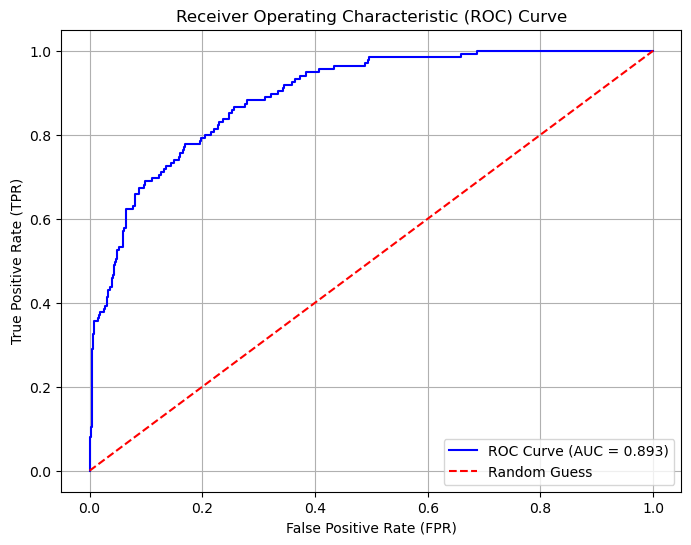

AUROC: 0.893


In [30]:
from sklearn.metrics import roc_curve, roc_auc_score
# Get predicted probabilities for positive class
xgb_probs = xgb_model.predict_proba(X_test_preprocessed)[:, 1]  # Probabilities for the positive class (class 1)
fpr, tpr, thresholds = roc_curve(y_test, xgb_probs, pos_label=xgb_model.classes_[1])
# Calculate the AUC (Area Under the Curve)
auc = roc_auc_score(y_test, xgb_probs)
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()
# Print the AUC score
print(f'AUROC: {auc:.3f}')

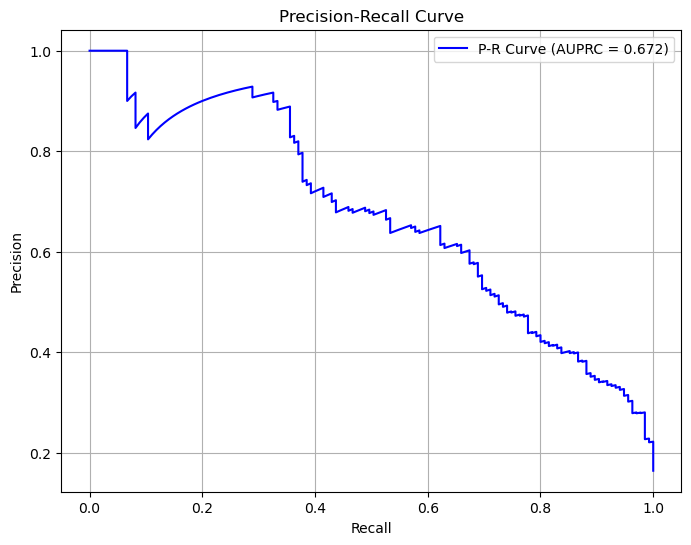

PRAUC: 0.672


In [31]:
from sklearn.metrics import precision_recall_curve, auc
# Get predicted probabilities for the positive class
xgb_probs = xgb_model.predict_proba(X_test_preprocessed)[:, 1]   # For scikit-learn models
# For Keras: y_probs = model.predict(X_test).flatten()
# Calculate P-R curve
precision, recall, thresholds = precision_recall_curve(y_test, xgb_probs)
pr_auc = auc(recall, precision)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'P-R Curve (AUPRC = {pr_auc:.3f})',color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()
# Print the pr-auc score
print(f'PRAUC: {pr_auc:.3f}')

In [32]:
thresholds1 = np.linspace(0.01, 0.99, 100)  # 100 points between 0.01-0.99
thresholds2 = np.arange(0.01,1.0,0.1)

In [33]:
thresholds2

array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91])

In [34]:
thresholds1

array([0.01      , 0.01989899, 0.02979798, 0.03969697, 0.04959596,
       0.05949495, 0.06939394, 0.07929293, 0.08919192, 0.09909091,
       0.1089899 , 0.11888889, 0.12878788, 0.13868687, 0.14858586,
       0.15848485, 0.16838384, 0.17828283, 0.18818182, 0.19808081,
       0.2079798 , 0.21787879, 0.22777778, 0.23767677, 0.24757576,
       0.25747475, 0.26737374, 0.27727273, 0.28717172, 0.29707071,
       0.3069697 , 0.31686869, 0.32676768, 0.33666667, 0.34656566,
       0.35646465, 0.36636364, 0.37626263, 0.38616162, 0.39606061,
       0.4059596 , 0.41585859, 0.42575758, 0.43565657, 0.44555556,
       0.45545455, 0.46535354, 0.47525253, 0.48515152, 0.49505051,
       0.50494949, 0.51484848, 0.52474747, 0.53464646, 0.54454545,
       0.55444444, 0.56434343, 0.57424242, 0.58414141, 0.5940404 ,
       0.60393939, 0.61383838, 0.62373737, 0.63363636, 0.64353535,
       0.65343434, 0.66333333, 0.67323232, 0.68313131, 0.6930303 ,
       0.70292929, 0.71282828, 0.72272727, 0.73262626, 0.74252

In [35]:
import numpy as np
from sklearn.metrics import f1_score, confusion_matrix  # Make sure to import these

# Your probabilities and thresholds
probabilities = xgb_model.predict_proba(X_test_preprocessed)  # Ensure this outputs shape (n_samples, 2)
thresholds = np.linspace(0.01, 0.99, 100)  # 100 points between 0.01-0.99

# Initialize lists to store metrics
f1_scores = []
gmeans = []

for threshold in thresholds:
    # Apply threshold
    predictions = (probabilities[:, 1] >= threshold).astype(int)
    
    # Calculate metrics (using imported functions)
    current_f1 = f1_score(y_test, predictions)  # Now using the sklearn function
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    current_gmean = np.sqrt(sensitivity * specificity)
    
    # Store results
    f1_scores.append(current_f1)
    gmeans.append(current_gmean)
    
    print(f"Threshold: {threshold:.3f} | F1: {current_f1:.3f} | G-mean: {current_gmean:.3f}")

# Find optimal thresholds
optimal_f1_threshold = thresholds[np.argmax(f1_scores)]
optimal_gmean_threshold = thresholds[np.argmax(gmeans)]

print(f"\nOptimal F1 Threshold: {optimal_f1_threshold:.3f} (F1 = {max(f1_scores):.3f})")
print(f"Optimal G-mean Threshold: {optimal_gmean_threshold:.3f} (G-mean = {max(gmeans):.3f})")

Threshold: 0.010 | F1: 0.363 | G-mean: 0.563
Threshold: 0.020 | F1: 0.432 | G-mean: 0.698
Threshold: 0.030 | F1: 0.465 | G-mean: 0.743
Threshold: 0.040 | F1: 0.489 | G-mean: 0.768
Threshold: 0.050 | F1: 0.496 | G-mean: 0.772
Threshold: 0.059 | F1: 0.505 | G-mean: 0.778
Threshold: 0.069 | F1: 0.517 | G-mean: 0.786
Threshold: 0.079 | F1: 0.533 | G-mean: 0.796
Threshold: 0.089 | F1: 0.542 | G-mean: 0.798
Threshold: 0.099 | F1: 0.550 | G-mean: 0.798
Threshold: 0.109 | F1: 0.555 | G-mean: 0.795
Threshold: 0.119 | F1: 0.562 | G-mean: 0.798
Threshold: 0.129 | F1: 0.566 | G-mean: 0.794
Threshold: 0.139 | F1: 0.575 | G-mean: 0.798
Threshold: 0.149 | F1: 0.588 | G-mean: 0.804
Threshold: 0.158 | F1: 0.581 | G-mean: 0.794
Threshold: 0.168 | F1: 0.590 | G-mean: 0.793
Threshold: 0.178 | F1: 0.592 | G-mean: 0.794
Threshold: 0.188 | F1: 0.599 | G-mean: 0.792
Threshold: 0.198 | F1: 0.599 | G-mean: 0.789
Threshold: 0.208 | F1: 0.603 | G-mean: 0.785
Threshold: 0.218 | F1: 0.614 | G-mean: 0.786
Threshold:

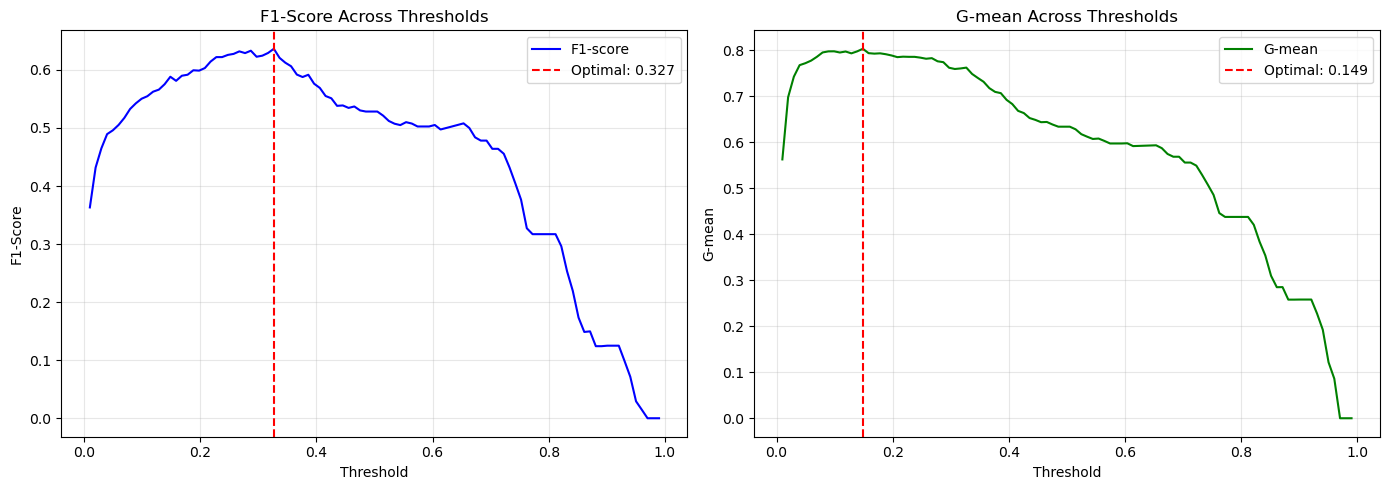

In [36]:
import matplotlib.pyplot as plt

# Create figure with two subplots side by side
plt.figure(figsize=(14, 5))

# F1-score plot (left subplot)
plt.subplot(1, 2, 1)  # 1 row, 2 columns, position 1
plt.plot(thresholds, f1_scores, color='blue', label='F1-score')
plt.axvline(x=optimal_f1_threshold, color='red', linestyle='--', 
            label=f'Optimal: {optimal_f1_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('F1-Score')
plt.title('F1-Score Across Thresholds')
plt.legend()
plt.grid(alpha=0.3)

# G-mean plot (right subplot)
plt.subplot(1, 2, 2)  # 1 row, 2 columns, position 2
plt.plot(thresholds, gmeans, color='green', label='G-mean')
plt.axvline(x=optimal_gmean_threshold, color='red', linestyle='--', 
            label=f'Optimal: {optimal_gmean_threshold:.3f}')
plt.xlabel('Threshold')
plt.ylabel('G-mean')
plt.title('G-mean Across Thresholds')
plt.legend()
plt.grid(alpha=0.3)

# Adjust layout and display
plt.tight_layout()
plt.show()

XGBoost Performance at Threshold = 0.327
--------------------------------------
G-mean: 0.763 
F1-score: 0.636 (Target: 0.528)
Accuracy: 0.883
MCC: 0.567
ROC AUC: 0.893
PR AUC: 0.672

Confusion Matrix:
[[644  45]
 [ 51  84]]


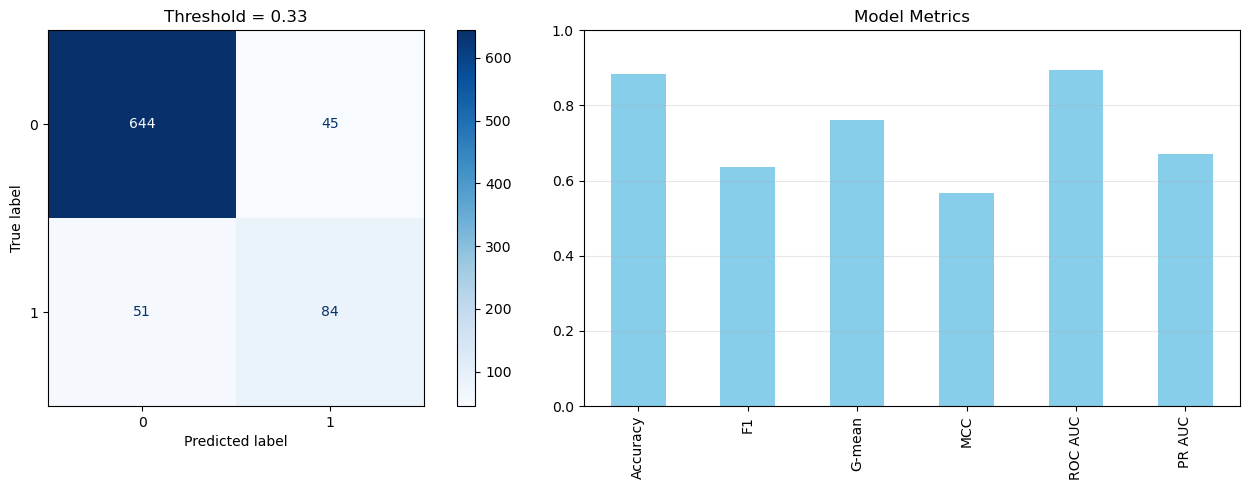


Threshold Optimization Insights:
- At threshold 0.327, we achieve maximum f1-measure 
- This threshold yields 62.2% recall and 93.5% specificity
- Compared to default 0.5 threshold:
  • f1-measure improvement: 0.108
  • Recall improvement: 0.207
  • G-mean improvement: 0.128
  • MCC improvement: 0.079
  • Accuracy improvement: 0.005


In [37]:
from sklearn.metrics import precision_score, recall_score  # Import precision_score and recall_score
def evaluate_xgboost(xgb_model, X_test_preprocessed, y_test, threshold=0.5):
    """Evaluate XGBoost model at specific threshold with all metrics"""
    # Get probabilities and predictions
    xgb_probs = xgb_model.predict_proba(X_test_preprocessed)[:, 1]
    y_pred = (xgb_probs >= threshold).astype(int)
    
    # Calculate confusion matrix
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # Compute all metrics
    metrics = {
        'Threshold': threshold,
        'Accuracy': accuracy_score(y_test, y_pred),
        'F1': f1_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'Specificity': tn / (tn + fp + 1e-8),
        'G-mean': np.sqrt(recall_score(y_test, y_pred) * (tn / (tn + fp + 1e-8))),
        'MCC': matthews_corrcoef(y_test, y_pred),
        'ROC AUC': roc_auc_score(y_test, xgb_probs),
        'PR AUC': auc(*precision_recall_curve(y_test, xgb_probs)[1::-1]),
        'Confusion Matrix': np.array([[tn, fp], [fn, tp]])
    }
    return metrics

# 2. Evaluate at optimal threshold 0.277
optimal_thresh = 0.327
results = evaluate_xgboost(xgb_model, X_test_preprocessed, y_test, threshold=optimal_thresh)

# 3. Display results
print("XGBoost Performance at Threshold = 0.327")
print("--------------------------------------")
print(f"G-mean: {results['G-mean']:.3f} ")
print(f"F1-score: {results['F1']:.3f} (Target: 0.528)")
print(f"Accuracy: {results['Accuracy']:.3f}")
print(f"MCC: {results['MCC']:.3f}")
print(f"ROC AUC: {results['ROC AUC']:.3f}")
print(f"PR AUC: {results['PR AUC']:.3f}")
print("\nConfusion Matrix:")
print(results['Confusion Matrix'])

# 4. Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
ConfusionMatrixDisplay(results['Confusion Matrix']).plot(ax=ax1, cmap='Blues')
ax1.set_title(f'Threshold = {optimal_thresh:.2f}')

# Metrics Comparison
metrics = ['Accuracy', 'F1', 'G-mean', 'MCC', 'ROC AUC', 'PR AUC']
pd.Series(results).loc[metrics].plot.bar(ax=ax2, color='skyblue')
ax2.set_title('Model Metrics')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Threshold Analysis Report
print("\nThreshold Optimization Insights:")
print(f"- At threshold 0.327, we achieve maximum f1-measure ")
print(f"- This threshold yields {results['Recall']:.1%} recall and {results['Specificity']:.1%} specificity")
print(f"- Compared to default 0.5 threshold:")
default_results = evaluate_xgboost(xgb_model, X_test_preprocessed, y_test, threshold=0.5)
print(f"  • f1-measure improvement: {results['F1'] - default_results['F1']:.3f}")
print(f"  • Recall improvement: {results['Recall'] - default_results['Recall']:.3f}")
print(f"  • G-mean improvement: {results['G-mean'] - default_results['G-mean']:.3f}")
print(f"  • MCC improvement: {results['MCC'] - default_results['MCC']:.3f}")
print(f"  • Accuracy improvement: {results['Accuracy'] - default_results['Accuracy']:.3f}")

XGBoost Performance at Threshold = 0.149
--------------------------------------
G-mean: 0.804 (Target: 0.634)
F1-score: 0.588
Accuracy: 0.822
MCC: 0.507
ROC AUC: 0.893
PR AUC: 0.672

Confusion Matrix:
[[572 117]
 [ 30 105]]


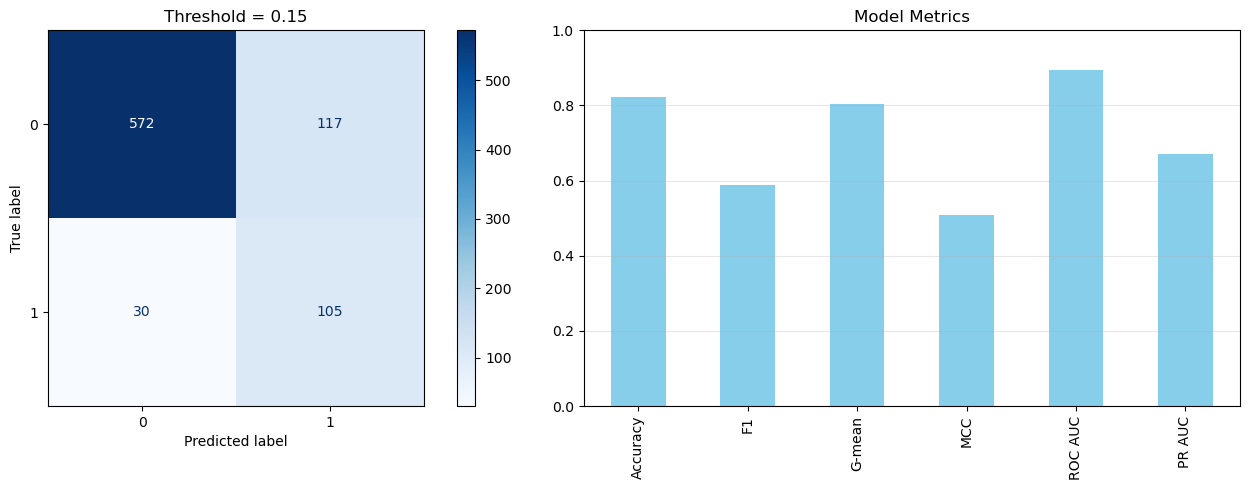


Threshold Optimization Insights:
- At threshold 0.149, we achieve maximum G-mean (balanced sensitivity/specificity)
- This threshold yields 77.8% recall and 83.0% specificity
- Compared to default 0.5 threshold:
  • G-mean improvement: 0.169
  • Recall improvement: 0.363
  • F1-score improvement: 0.060
  • MCC improvement: 0.018
  • Accuracy improvement: -0.057


In [38]:
from sklearn.metrics import precision_score, recall_score  # Import precision_score and recall_score
# Evaluate at optimal threshold 0.149
optimal_thresh = 0.149
results = evaluate_xgboost(xgb_model, X_test_preprocessed, y_test, threshold=optimal_thresh)

# 3. Display results
print("XGBoost Performance at Threshold = 0.149")
print("--------------------------------------")
print(f"G-mean: {results['G-mean']:.3f} (Target: 0.634)")
print(f"F1-score: {results['F1']:.3f}")
print(f"Accuracy: {results['Accuracy']:.3f}")
print(f"MCC: {results['MCC']:.3f}")
print(f"ROC AUC: {results['ROC AUC']:.3f}")
print(f"PR AUC: {results['PR AUC']:.3f}")
print("\nConfusion Matrix:")
print(results['Confusion Matrix'])

# 4. Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Confusion Matrix
ConfusionMatrixDisplay(results['Confusion Matrix']).plot(ax=ax1, cmap='Blues')
ax1.set_title(f'Threshold = {optimal_thresh:.2f}')

# Metrics Comparison
metrics = ['Accuracy', 'F1', 'G-mean', 'MCC', 'ROC AUC', 'PR AUC']
pd.Series(results).loc[metrics].plot.bar(ax=ax2, color='skyblue')
ax2.set_title('Model Metrics')
ax2.set_ylim(0, 1)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 5. Threshold Analysis Report
print("\nThreshold Optimization Insights:")
print(f"- At threshold 0.149, we achieve maximum G-mean (balanced sensitivity/specificity)")
print(f"- This threshold yields {results['Recall']:.1%} recall and {results['Specificity']:.1%} specificity")
print(f"- Compared to default 0.5 threshold:")
default_results = evaluate_xgboost(xgb_model, X_test_preprocessed, y_test, threshold=0.5)
print(f"  • G-mean improvement: {results['G-mean'] - default_results['G-mean']:.3f}")
print(f"  • Recall improvement: {results['Recall'] - default_results['Recall']:.3f}")
print(f"  • F1-score improvement: {results['F1'] - default_results['F1']:.3f}")
print(f"  • MCC improvement: {results['MCC'] - default_results['MCC']:.3f}")
print(f"  • Accuracy improvement: {results['Accuracy'] - default_results['Accuracy']:.3f}")

# weighted

In [16]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split, GridSearchCV, RepeatedStratifiedKFold
from collections import Counter
from sklearn.utils.class_weight import compute_class_weight

In [17]:
# Compute class distribution
counter = Counter(y_train)
scale_pos_weight = counter[0] / counter[1]
print(f"Estimated scale_pos_weight: {scale_pos_weight:.2f}")


Estimated scale_pos_weight: 5.10


In [18]:

# Define parameter grid for scale_pos_weight and other hyperparameters
param_grid = {
    'scale_pos_weight': [1, 2, 3, 5.36],  # Your new estimate
    'max_depth': [3, 5],
    'learning_rate': [0.01, 0.1,0.2],
    'n_estimators': [20, 50],
    'gamma': [0, 0.1, 0.2],
    'colsample_bytree': [0.6, 0.8],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.8, 1.0]
}
# Define cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=101)

# Initialize XGBClassifier
model = XGBClassifier(use_label_encoder=False, eval_metric='logloss',random_state=101)
# Set up GridSearchCV
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='roc_auc',
                    n_jobs=-1, cv=cv, verbose=1)

# Fit the grid search
grid_result = grid.fit(X_train_preprocessed, y_train_clean)

# Print the best parameters and score
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

Fitting 10 folds for each of 1728 candidates, totalling 17280 fits
Best: 0.889718 using {'colsample_bytree': 0.6, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 50, 'scale_pos_weight': 1, 'subsample': 0.8}


In [43]:
'''
best_model = grid_result.best_estimator_
y_pred_proba = best_model.predict_proba(X_test_preprocessed)[:,1]
# Compute metrics like ROC AUC, F1, G-mean, MCC, etc.
y_pred = best_model.predict(X_test_preprocessed)
'''

In [20]:

xgb_model_w= XGBClassifier(use_label_encoder=False, eval_metric='logloss',colsample_bytree=0.6,gamma=0.1,
learning_rate=0.1,max_depth=3, min_child_weight=1,n_estimators=50,subsample =0.8,random_state=101,scale_pos_weight=1.0)
xgb_model_w.fit(X_train_preprocessed, y_train_clean)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=0.1,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=50, n_jobs=None,
              num_parallel_tree=None, ...)

In [21]:

y_pred_w = xgb_model_w.predict(X_test_preprocessed)
xgb_probs_w = xgb_model_w.predict_proba(X_test_preprocessed)[:, 1]  # Probabilities for the positive class (class 1)


In [22]:
# Evaluate best model XGBoost
accuracy = accuracy_score(y_test, y_pred_w)
print("\nOptimized Test Accuracy:",accuracy)


Optimized Test Accuracy: 0.8798543689320388


In [25]:
from sklearn.metrics import f1_score, matthews_corrcoef, confusion_matrix
import numpy as np

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_w).ravel()
sensitivity = tp / (tp + fn)
specificity = tn / (tn + fp)

mcc = matthews_corrcoef(y_test, y_pred_w)
g_mean = np.sqrt(sensitivity * specificity)
f1 = f1_score(y_test, y_pred_w)  # Use a different variable name
accuracy =accuracy_score(y_test, y_pred_w)
# Print results
print(f"Accuracy: {accuracy:.3f}")
print(f"Sensitivity (Recall): {sensitivity:.3f}")
print(f"Specificity: {specificity:.3f}")
print(f"G-mean: {g_mean:.3f}")
print(f"MCC: {mcc:.3f}")
print(f"F1 Score: {f1:.3f}")

Accuracy: 0.880
Sensitivity (Recall): 0.422
Specificity: 0.970
G-mean: 0.640
MCC: 0.495
F1 Score: 0.535


In [26]:
print(classification_report(y_test, y_pred_w))

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       689
           1       0.73      0.42      0.54       135

    accuracy                           0.88       824
   macro avg       0.81      0.70      0.73       824
weighted avg       0.87      0.88      0.87       824



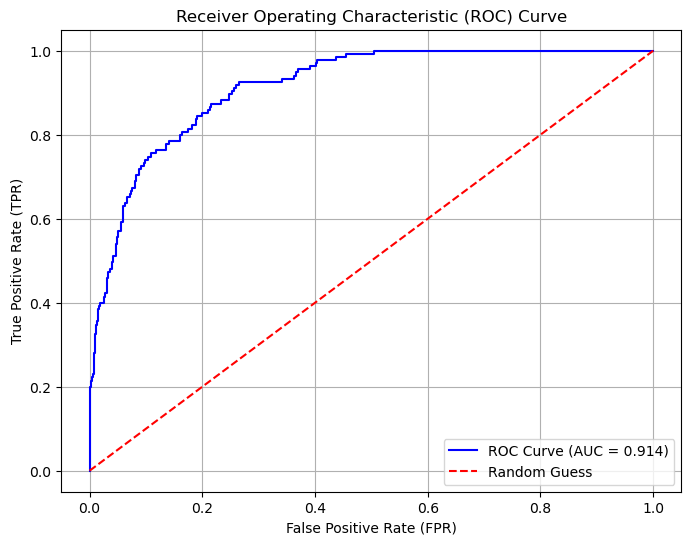

AUROC: 0.914


In [47]:
from sklearn.metrics import roc_curve, roc_auc_score
# Get predicted probabilities for positive class
y_pred_proba = xgb_probs_w.predict_proba(X_test_preprocessed)[:, 1]  # Probabilities for the positive class (class 1)
fpr, tpr, thresholds = roc_curve(y_test, xgb_probs_w, pos_label=best_model.classes_[1])
# Calculate the AUC (Area Under the Curve)
auc = roc_auc_score(y_test, xgb_probs_w)
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc:.3f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.grid(True)
plt.show()
# Print the AUC score
print(f'AUROC: {auc:.3f}')

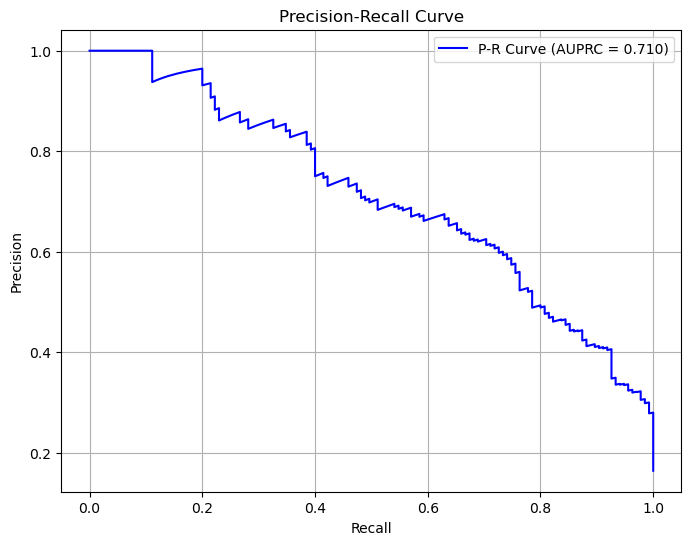

PRAUC: 0.710


In [27]:
from sklearn.metrics import precision_recall_curve, auc
# Get predicted probabilities for the positive class
y_pred_proba = xgb_model_w.predict_proba(X_test_preprocessed)[:, 1]   # For scikit-learn models
# Calculate P-R curve
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

# Plot
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'P-R Curve (AUPRC = {pr_auc:.3f})',color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()
# Print the pr-auc score
print(f'PRAUC: {pr_auc:.3f}')